<a href="https://colab.research.google.com/github/scott-huberty/DeepUnderstandingOfDeepLearning/blob/codechallenges/metaparams/DUDL_data_CodeChallengeUbalanced_Scott.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Compare relu variants
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [15]:
def get_dataset(quality_threshold):
  # First read the data
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
  df = pd.read_csv(url, sep=';')

  # Outliers
  df = df[df['total sulfur dioxide'] < 200]

  # Z-score
  predictors = df.columns.drop(["quality"])
  df[predictors] = df[predictors].apply(stats.zscore)

  # Binarize the quality
  df['boolQuality'] = 0
  df.loc[df["quality"] > quality_threshold, "boolQuality"] = 1
  return df


def create_dataloaders(quality_threshold):
  df = get_dataset(quality_threshold)

  X = df.drop(['quality','boolQuality'], axis=1)
  y = df["boolQuality"].values

  predictors = torch.tensor(X.values, dtype=torch.float)
  labels = torch.tensor(y, dtype=torch.float)
  labels = labels[: ,None] # transform to matrix

  train_data, test_data, train_labels, test_labels = train_test_split(predictors, labels, test_size=0.1)

  train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
  test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

  batch_size = 64
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0] )

  return train_loader, test_loader

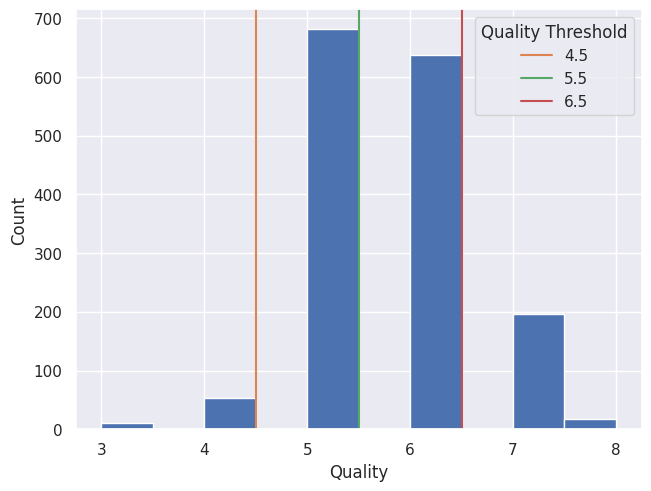

63 bad wines and 1534 good wines
Percent Bad rated wines: 0.04
744 bad wines and 853 good wines
Percent Bad rated wines: 0.47
1382 bad wines and 215 good wines
Percent Bad rated wines: 0.87


In [36]:
data1 = get_dataset(quality_threshold=4.5)
data2 = get_dataset(quality_threshold=5.5)
data3 = get_dataset(quality_threshold=6.5)

fig, ax = plt.subplots(constrained_layout=True)
sns.set(style="darkgrid")
colors = sns.color_palette()

ax.hist(data1["quality"])
ax.axvline(4.5, color=colors[1], label="4.5")
ax.axvline(5.5, color=colors[2], label="5.5")
ax.axvline(6.5, color=colors[3], label="6.5")
ax.legend(title="Quality Threshold")
ax.set_xlabel("Quality")
ax.set_ylabel("Count")
plt.show()

for data in [data1, data2, data3]:
  bad = data.loc[data["boolQuality"] == 0]
  good = data.loc[data["boolQuality"] == 1]
  print(f"{len(bad)} bad wines and {len(good)} good wines")
  perc = len(bad) / (len(bad) + len(good))
  # format to 2 decimals
  print(f"Percent Bad rated wines: {perc:.2f}")

# Now for the DL part

In [12]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11, 16)

    ### hidden layers
    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    ### output layer
    self.output = nn.Linear(32, 1)

    self.leakyrelu = nn.LeakyReLU()

  # forward pass
  def forward(self, x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    x = self.leakyrelu(self.input(x))
    x = self.leakyrelu(self.fc1(x))
    x = self.leakyrelu(self.fc2(x))
    return self.output(x)

# Train the model

In [42]:
NUM_EPOCHS = 500

def compute_accuracy(predictions, labels, split_by_group=False):
  """Compute accuracy for binary classification."""
  if split_by_group:
    item_accuracy = ((predictions > 0) == labels).float()
    accuracy_dict = {
        "bad": 100 * torch.mean(item_accuracy[labels == 0]),
        "good": 100 * torch.mean(item_accuracy[labels == 1]),
    }
    return accuracy_dict
  else:
    return 100 * torch.mean(((predictions > 0) == labels).float()).item()

def train_the_model(quality_threshold, num_epochs=500):
  """Train the Winet Model."""
  train_loader, test_loader = create_dataloaders(quality_threshold=quality_threshold)
  winenet = ANNwine()

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(), lr=.001)

  # initialize losses
  losses   = torch.zeros(num_epochs)
  trainAcc = []
  test_acc_good  = []
  test_acc_bad  = []
  testAcc = []

  # loop over epochs
  for epochi in range(num_epochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for predictors, labels in train_loader:

      # forward pass and loss
      predictions = winenet(predictors)
      loss = lossfun(predictions, labels)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      accuracy = compute_accuracy(predictions, labels)
      batchAcc.append(accuracy)
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X, y = next(iter(test_loader)) # extract X, y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    accuracy = compute_accuracy(yHat, y)
    accuracies = compute_accuracy(yHat, y, split_by_group=True)
    true_bad = accuracies["bad"]
    true_good = accuracies["good"]
    testAcc.append(accuracy)
    test_acc_good.append(true_good)
    test_acc_bad.append(true_bad)

  return trainAcc, testAcc, losses, test_acc_good, test_acc_bad

In [43]:
thresholds = [4.5, 5.5, 6.5]

train_results = np.zeros((NUM_EPOCHS, len(thresholds)))
test_results  = np.zeros((NUM_EPOCHS, len(thresholds)))
losses = np.zeros((NUM_EPOCHS, len(thresholds)))
test_results_good = np.zeros((NUM_EPOCHS, len(thresholds)))
test_results_bad = np.zeros((NUM_EPOCHS, len(thresholds)))

for ti, this_threshold in enumerate(thresholds):
  # create a model and train it
  (train_results[:, ti],
   test_results[:, ti],
   losses[:, ti],
   test_results_good[:, ti],
   test_results_bad[:, ti]) = train_the_model(this_threshold)


In [46]:
test_results_good[1, 0]

100.0

In [47]:
np.mean(test_results_good[:, 0]), np.mean(test_results_bad[:, 0])


(96.59870907592773, 17.32)

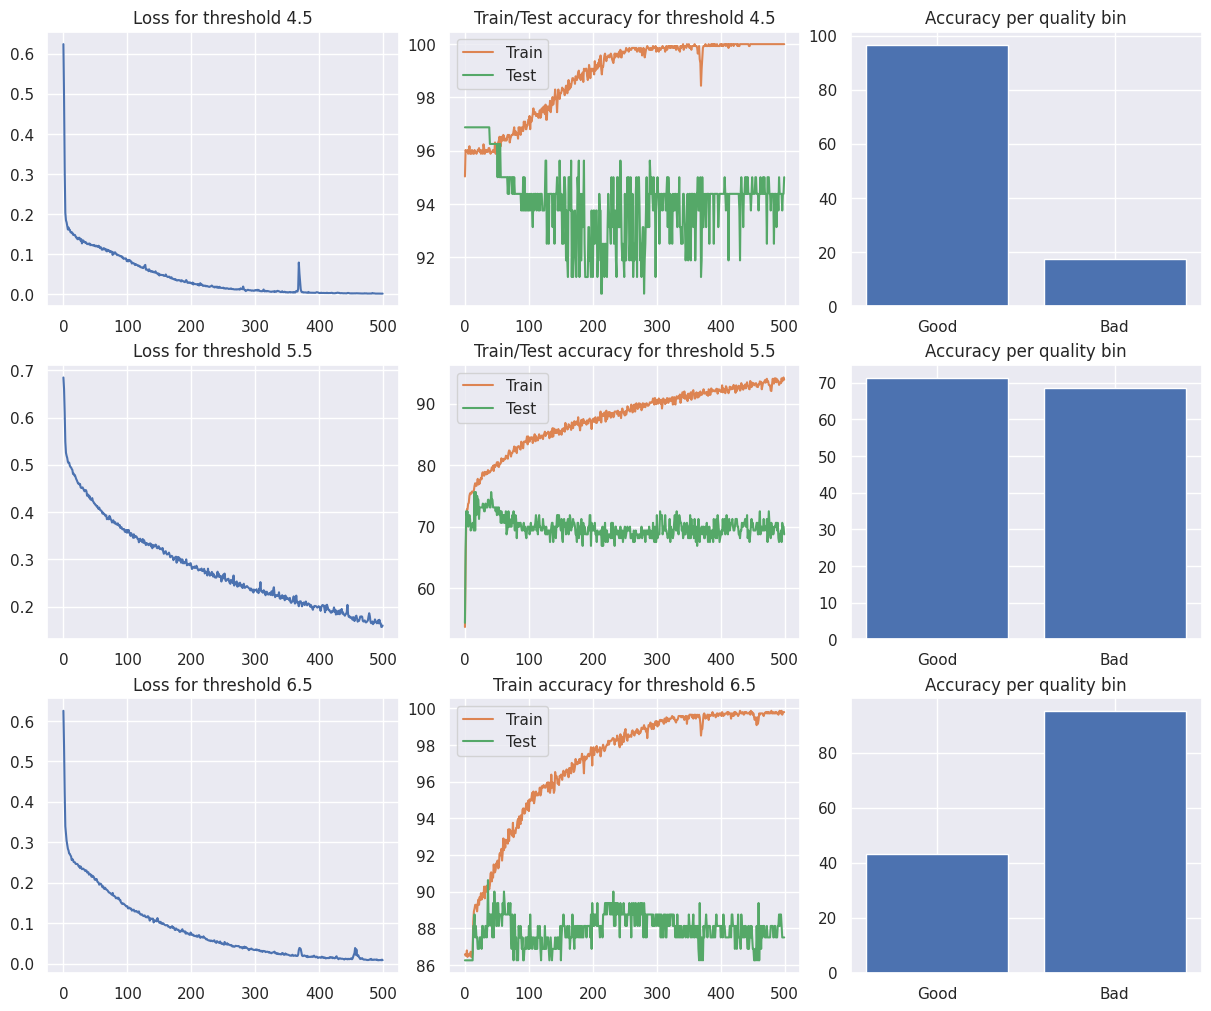

In [52]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10), constrained_layout=True)
colors = sns.color_palette()

axes[0, 0].plot(losses[:, 0])
axes[0, 0].set_title('Loss for threshold 4.5')
axes[0, 1].plot(train_results[:, 0], color=colors[1], label="Train")
axes[0, 1].plot(test_results[:, 0], color=colors[2], label="Test")
axes[0, 1].set_title('Train/Test accuracy for threshold 4.5')
axes[0, 1].legend()
# Accuracy computed per quality bin
good_acc, bad_acc = np.mean(test_results_good[:, 0]), np.mean(test_results_bad[:, 0])
axes[0, 2].bar(["Good", "Bad"], [good_acc, bad_acc])
axes[0, 2].set_title("Accuracy per quality bin")




axes[1, 0].plot(losses[:, 1])
axes[1, 0].set_title('Loss for threshold 5.5')
axes[1, 1].plot(train_results[:, 1], color=colors[1], label="Train")
axes[1, 1].plot(test_results[:, 1], color=colors[2], label="Test")
axes[1, 1].set_title('Train/Test accuracy for threshold 5.5')
axes[1, 1].legend()
# Accuracy computed per quality bin
good_acc, bad_acc = np.mean(test_results_good[:, 1]), np.mean(test_results_bad[:, 1])
axes[1, 2].bar(["Good", "Bad"], [good_acc, bad_acc])
axes[1, 2].set_title("Accuracy per quality bin")

axes[2, 0].plot(losses[:, 2])
axes[2, 0].set_title('Loss for threshold 6.5')
axes[2, 1].plot(train_results[:, 2], color=colors[1], label="Train")
axes[2, 1].plot(test_results[:, 2], color=colors[2], label="Test")
axes[2, 1].set_title('Train accuracy for threshold 6.5')
axes[2, 1].legend()
# Accuracy computed per quality bin
good_acc, bad_acc = np.mean(test_results_good[:, 2]), np.mean(test_results_bad[:, 2])
axes[2, 2].bar(["Good", "Bad"], [good_acc, bad_acc])
axes[2, 2].set_title("Accuracy per quality bin")
# display text of the number of good wines and the number of bad wines
n_bad_wines = len(data3.loc[data3["boolQuality"] == 0])
n_good_wins = len(data3.loc[data3["boolQuality"] == 1])

plt.show()


# Additional explorations

In [ ]:
# This was a pretty straightforward codeChallenge, so there isn't much to expand. Feel free to try exploring the
# standard DL metaparameters, including learning rate, number of training epochs, and batch size.
#
# It's also interesting the include other activation functions into the comparison. The following site lists the functions.
#   https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
